# Import libraries

In [93]:
import pandas as pd
import numpy as np
from numpy import sort
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

# Read data

In [2]:
df = pd.read_csv (r'data/2015.csv')
# display(df.describe)
# display(df.head)
# display(df.dtypes.value_counts())

# Preprocessing and Data cleaning

In [3]:
df.shape

(441456, 330)

In [27]:
# Create a copy of the data dataframe
dataset = df.copy()

In [28]:
# Drop empty columns
dataset.dropna(inplace=True, axis=1, how='all')

In [29]:
# Drop columns where all values are the same. This means there is no variation in the data. Check for columns where std = 0. 
std_indices = dataset.std()[(dataset.std() == 0)].index
dataset.drop(std_indices, axis=1, inplace=True)

In [30]:
dataset.shape

(441456, 321)

In [31]:
# Drop columns that start with '_' since those are mostly columns derived from other columns
# Keep the following columns: _RACE, _FRUTSUM, _VEGESUM, _BMI5CAT, _PACAT1, _AGEG5YR
for col in dataset.columns:
    if col.startswith('_') and col not in ["_RACE","_FRUTSUM","_VEGESUM","_BMI5CAT","_PACAT1","_AGEG5YR"]:
        dataset.drop(col, axis=1, inplace = True)

In [32]:
# Drop columns with 95% of missing values
dataset = dataset.loc[:, dataset.isnull().sum() < 0.95*dataset.shape[0]]

In [33]:
dataset.shape

(441456, 186)

In [34]:
# Keep columns with datatype float64 to keep columns with categorical values only. 
# Columns IDATE, IMONTH, IDAY, and IYEAR can be drop as they represent the interview date which is irrelevant for predictions
dataset = dataset.select_dtypes(include=['float64'])

In [35]:
dataset.shape

(441456, 179)

In [38]:
# Get rows where CHCOCNCR or CHCSCNCR = 1 or 2 from the dataset. Ignore rows where CHCOCNCR or CHCSCNCR = 7 or 9.
# CHCOCNCR = Any cancer
dataset = dataset.loc[(dataset['CHCOCNCR'].isin([1, 2]) | dataset['CHCSCNCR'].isin([1, 2]))]
dataset.reset_index(drop=True, inplace=True)

In [39]:
dataset.shape

(441257, 179)

In [46]:
labels_skin_cancer = np.where(dataset['CHCSCNCR']==1, 1, 0)
labels_other_cancer = np.where(dataset['CHCOCNCR']==1, 1, 0)
labels_both = np.where((dataset['CHCSCNCR']==1) | (dataset['CHCOCNCR']==1), 1, 0)

In [48]:
display(dataset.shape)
display(Counter(label_skin_cancer==1))
display(Counter(labels_other_cancer==1))
display(Counter(labels_both==1))

(441257, 179)

Counter({False: 399481, True: 41776})

Counter({False: 397816, True: 43441})

Counter({False: 365293, True: 75964})

In [49]:
# Remove the labels (CHCSCNCR and CHCOCNCR column) from the dataset
dataset.drop(['CHCSCNCR'], axis=1, inplace=True)
dataset.drop(['CHCOCNCR'], axis=1, inplace=True)


In [50]:
dataset.shape

(441257, 177)

In [51]:
# Check correlation of columns using a correlation matrix. For this fill in NA values first.
# Followed the code in this page: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
dataset2 = dataset.fillna(-1)
correlation_matrix = dataset2.corr().abs()

In [52]:
correlation_matrix

,FMONTH,DISPCODE,SEQNO,PVTRESD1,CELLFON3,NUMADULT,NUMMEN,NUMWOMEN,CELLFON2,CADULT,...,PAFREQ2_,STRFREQ_,PAMISS1_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_,_PACAT1
FMONTH,1.000000,0.006047,0.248085,0.009310,0.007294,0.006556,0.005271,0.008935,0.009326,0.009146,...,0.010034,0.009179,0.005637,0.023884,0.016242,0.026402,0.019297,0.017484,0.024355,0.010700
DISPCODE,0.006047,1.000000,0.053415,0.141480,0.138943,0.127957,0.123913,0.129782,0.141512,0.134256,...,0.120332,0.104198,0.712726,0.106333,0.074625,0.118766,0.077787,0.061939,0.092728,0.539418
SEQNO,0.248085,0.053415,1.000000,0.577591,0.561688,0.529129,0.510602,0.534632,0.577630,0.557269,...,0.003443,0.018181,0.041623,0.012902,0.010500,0.015332,0.038000,0.026427,0.043366,0.019902
PVTRESD1,0.009310,0.141480,0.577591,1.000000,0.957564,0.915232,0.883105,0.926053,0.999947,0.967086,...,0.013067,0.035864,0.044787,0.028371,0.025575,0.035217,0.071731,0.054013,0.084253,0.022858
CELLFON3,0.007294,0.138943,0.561688,0.957564,1.000000,0.876584,0.845894,0.887316,0.957625,0.926156,...,0.011823,0.037991,0.046097,0.022968,0.023385,0.030147,0.065959,0.050526,0.077982,0.022375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA1MIN_,0.026402,0.118766,0.015332,0.035217,0.030147,0.028693,0.035011,0.023770,0.035239,0.038563,...,0.419808,0.126348,0.155034,0.800938,0.732930,1.000000,0.643640,0.567520,0.803269,0.400328
PAVIG11_,0.019297,0.077787,0.038000,0.071731,0.065959,0.051912,0.055787,0.053956,0.071746,0.070701,...,0.147587,0.066374,0.087321,0.811956,0.134847,0.643640,1.000000,0.141032,0.816207,0.237606
PAVIG21_,0.017484,0.061939,0.026427,0.054013,0.050526,0.039914,0.041242,0.042460,0.054034,0.052702,...,0.294576,0.050902,0.068504,0.152528,0.759097,0.567520,0.141032,1.000000,0.687094,0.185947
PA1VIGM_,0.024355,0.092728,0.043366,0.084253,0.077982,0.061435,0.065041,0.064451,0.084276,0.082727,...,0.279690,0.078029,0.103342,0.684627,0.541795,0.803269,0.816207,0.687094,1.000000,0.281744


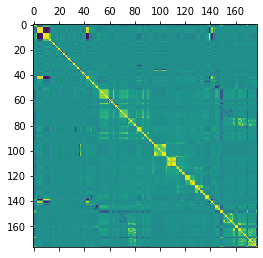

In [53]:
plt.matshow(dataset2.corr())
plt.show()

In [54]:
# Get correlations from the upper triangle in the correlation matrix
utriangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

In [55]:
# Find columns with correlation greater than 0.90
high_correlated_columns = [col for col in utriangle.columns if any (utriangle[col] > 0.90)]

In [56]:
high_correlated_columns

['CELLFON3',
 'NUMADULT',
 'NUMMEN',
 'NUMWOMEN',
 'CELLFON2',
 'CADULT',
 'PVTRESD2',
 'CSTATE',
 'LANDLINE',
 'BPMEDS',
 'NUMHHOL2',
 'CPDEMO1',
 'ARTHSOCL',
 'EYEEXAM',
 'DIABEYE',
 'DIABEDU',
 'CRGVHOUS',
 'CRGVMST2',
 'DRADVISE',
 'HADPAP2',
 'HADHYST2',
 'HADSIGM3',
 'LASTSIG3',
 'SCNTMEL1',
 'QSTVER',
 'HTM4',
 'DROCDY3_',
 'FC60_']

In [57]:
# Drop high correlated columns from the dataset
dataset.drop(high_correlated_columns, axis=1, inplace=True)

In [58]:
# Drop other columns not related to health manually
dataset.drop(columns = ['FMONTH','DISPCODE','SEQNO','PVTRESD1','HHADULT'], axis=1, inplace = True)

In [59]:

dataset.shape

(441257, 144)

In [60]:
# Normalize dataset
scaler = StandardScaler()
dataset_norm = scaler.fit_transform(dataset)

In [61]:
dataset_norm.shape

(441257, 144)

In [62]:
num_vars = dataset.columns[dataset.dtypes != 'object']
cat_vars = dataset.columns[dataset.dtypes == 'object']

print(num_vars)
print(cat_vars)

Index(['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'HLTHPLN1', 'PERSDOC2',
       'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BLOODCHO',
       ...
       'PAFREQ2_', 'STRFREQ_', 'PAMISS1_', 'PAMIN11_', 'PAMIN21_', 'PA1MIN_',
       'PAVIG11_', 'PAVIG21_', 'PA1VIGM_', '_PACAT1'],
      dtype='object', length=144)
Index([], dtype='object')


# Train Test Split

In [76]:
# Get feature importance using XGBClassifier from XGBoost
# Followed the code in this page: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

# Divide data in training and test
X_train, X_test, y_train, y_test = train_test_split(dataset_norm, labels_both, shuffle=True, test_size=0.2, random_state=42)
X_train_df = pd.DataFrame(data = X_train, columns=dataset.columns)
X_train_df.head()

,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,BPHIGH4,BLOODCHO,...,PAFREQ2_,STRFREQ_,PAMISS1_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_,_PACAT1
0,-0.517846,0.737941,0.650674,NaN,-0.197904,-0.474429,0.203306,-0.45968,-1.167123,-0.264408,...,-0.397623,0.796214,-0.326529,3.063161,0.554918,2.531176,3.730060,0.910356,3.325649,-0.914169
1,-0.517846,0.737941,0.650674,NaN,-0.197904,-0.474429,0.203306,-0.45968,-1.167123,-0.264408,...,-0.042149,-0.530776,-0.326529,1.003463,-0.097400,0.659884,1.434728,-0.268208,0.911744,-0.914169
2,0.377461,0.737941,0.650674,NaN,-0.197904,-0.474429,0.203306,-0.45968,-1.167123,-0.264408,...,-0.669641,-0.088446,-0.326529,-0.140813,-0.316229,-0.287180,0.159543,-0.268208,-0.036125,-0.509003
3,1.272768,-1.366971,-1.748568,0.846654,-0.197904,-0.474429,0.203306,-0.45968,0.764255,-0.264408,...,1.066316,-0.221145,-0.326529,-0.255241,0.029729,-0.144785,-0.350531,-0.268208,-0.415272,-0.914169
4,0.377461,0.737941,0.650674,NaN,-0.197904,0.726839,0.203306,-0.45968,-1.167123,-0.264408,...,NaN,-0.530776,-0.326529,NaN,NaN,NaN,NaN,NaN,NaN,0.301330


In [77]:
display(X_test.shape)
display(y_test.shape)
display(X_train.shape)
display(y_train.shape)

(88252, 144)

(88252,)

(353005, 144)

(353005,)

In [78]:
X_test_df = pd.DataFrame(data = X_test, columns=dataset.columns)
X_test_df.head()

,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,BPHIGH4,BLOODCHO,...,PAFREQ2_,STRFREQ_,PAMISS1_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_,_PACAT1
0,0.377461,0.737941,0.650674,NaN,-0.197904,-0.474429,0.203306,-0.45968,-1.167123,-0.264408,...,1.212836,-0.530776,-0.326529,-0.484096,0.496564,-0.005076,-0.223013,-0.268208,-0.320485,-0.914169
1,1.272768,-1.555873,0.650674,0.846654,-0.197904,0.726839,0.203306,0.34158,-1.167123,-0.264408,...,NaN,-0.530776,-0.326529,NaN,NaN,NaN,NaN,NaN,NaN,0.301330
2,-0.517846,-1.474915,0.957553,0.846654,1.766037,-0.474429,0.203306,-0.45968,0.764255,-0.264408,...,NaN,-0.530776,-0.326529,-0.117928,-0.378752,-0.311361,-0.350531,-0.268208,-0.415272,-0.509003
3,0.377461,0.737941,0.650674,NaN,1.766037,1.928108,-2.213911,1.94410,0.764255,0.830146,...,0.114724,2.049335,-0.326529,-0.320083,-0.086980,-0.265687,-0.350531,-0.268208,-0.415272,-0.509003
4,1.272768,0.441094,0.650674,-1.070825,-0.197904,-0.474429,0.203306,-0.45968,6.558388,-0.264408,...,NaN,NaN,3.249203,NaN,NaN,NaN,NaN,NaN,NaN,2.327162


# XG Boost

In [79]:
# Fit model
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train_df, y_train)

[17:23:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [80]:
dataset.shape

(441257, 144)

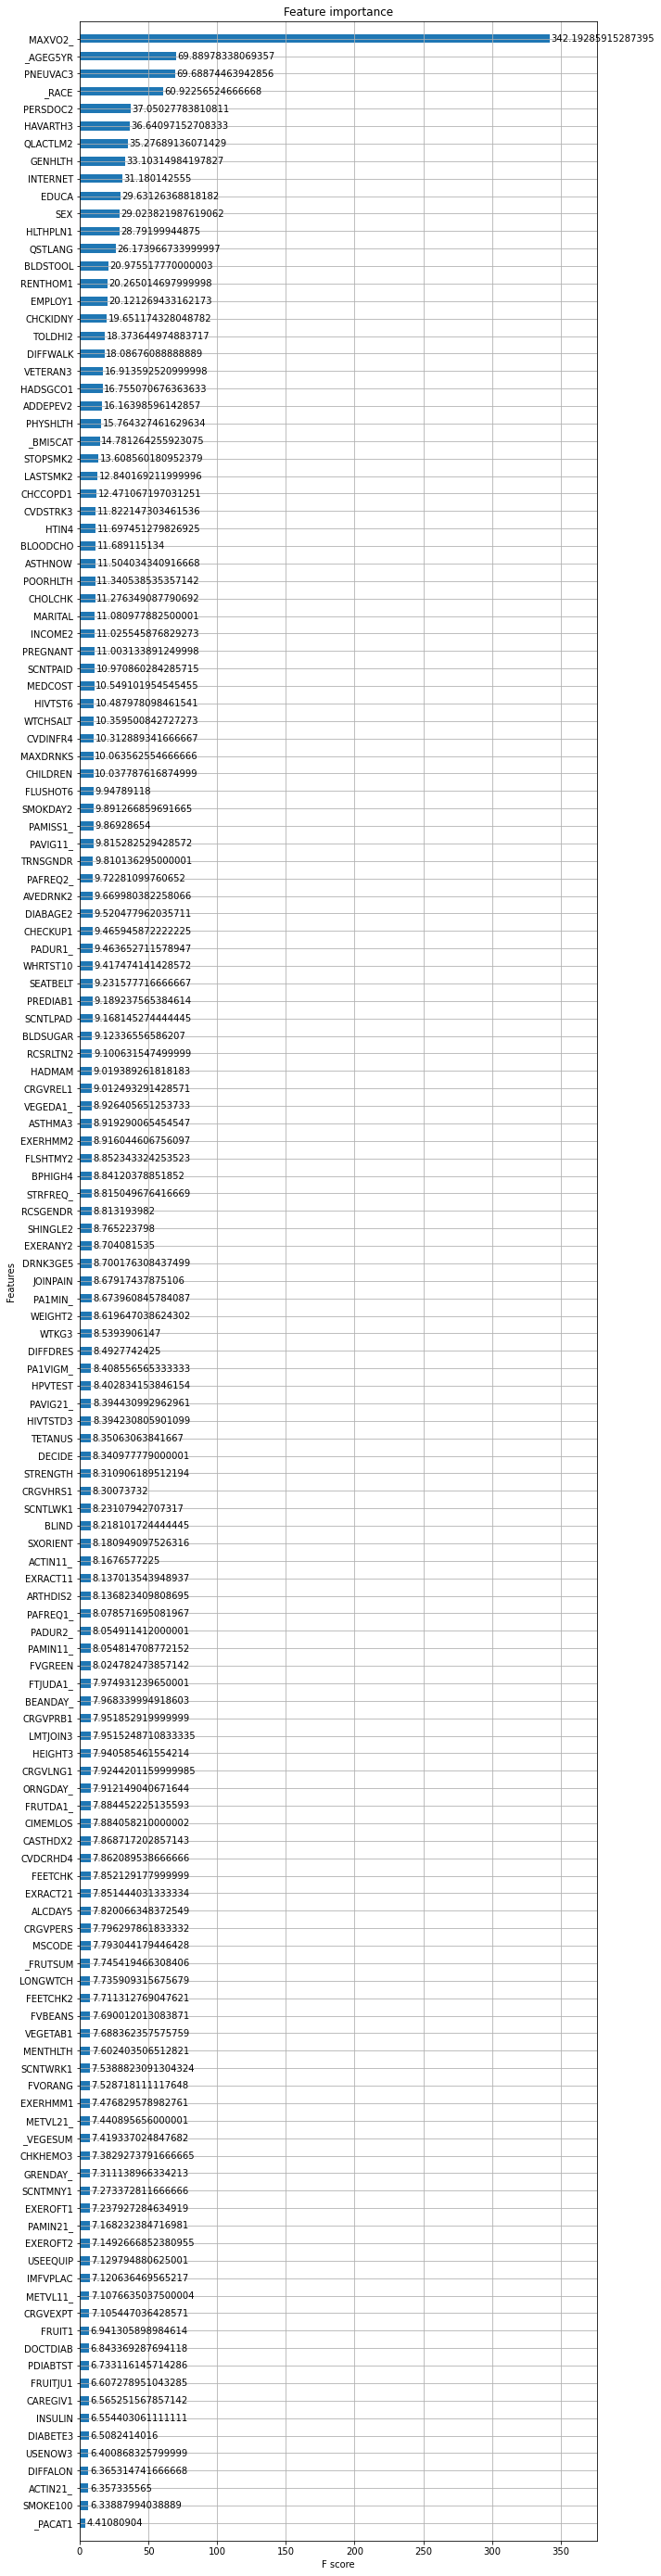

In [81]:
# Plot feature importance
ax = plot_importance(model, height=0.5, importance_type="gain")

fig = ax.figure
fig.set_size_inches(10, 50)

In [82]:
y_true, y_pred = y_test, model.predict(X_test_df)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90     72962
           1       0.54      0.11      0.19     15290

    accuracy                           0.83     88252
   macro avg       0.69      0.55      0.55     88252
weighted avg       0.79      0.83      0.78     88252



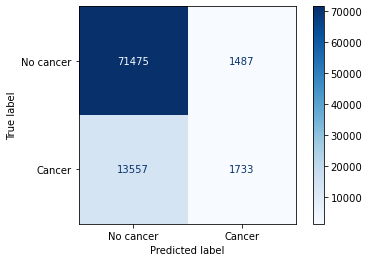

In [83]:
plot_confusion_matrix(model, X_test_df, y_test, display_labels=['No cancer',
 'Cancer'], cmap=plt.cm.Blues)

In [85]:
# Trying to fix the imbalanced classification
# Followed the code from this page: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

# Estimate scale_pos_weight value
# counter = Counter(y_pred)
counter = Counter(labels_both)
display(counter)
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Counter({0: 365293, 1: 75964})

Estimate: 4.809


In [86]:
model = XGBClassifier(use_label_encoder=False, scale_pos_weight=4.9)
model.fit(X_train_df, y_train)

[17:27:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4.9, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

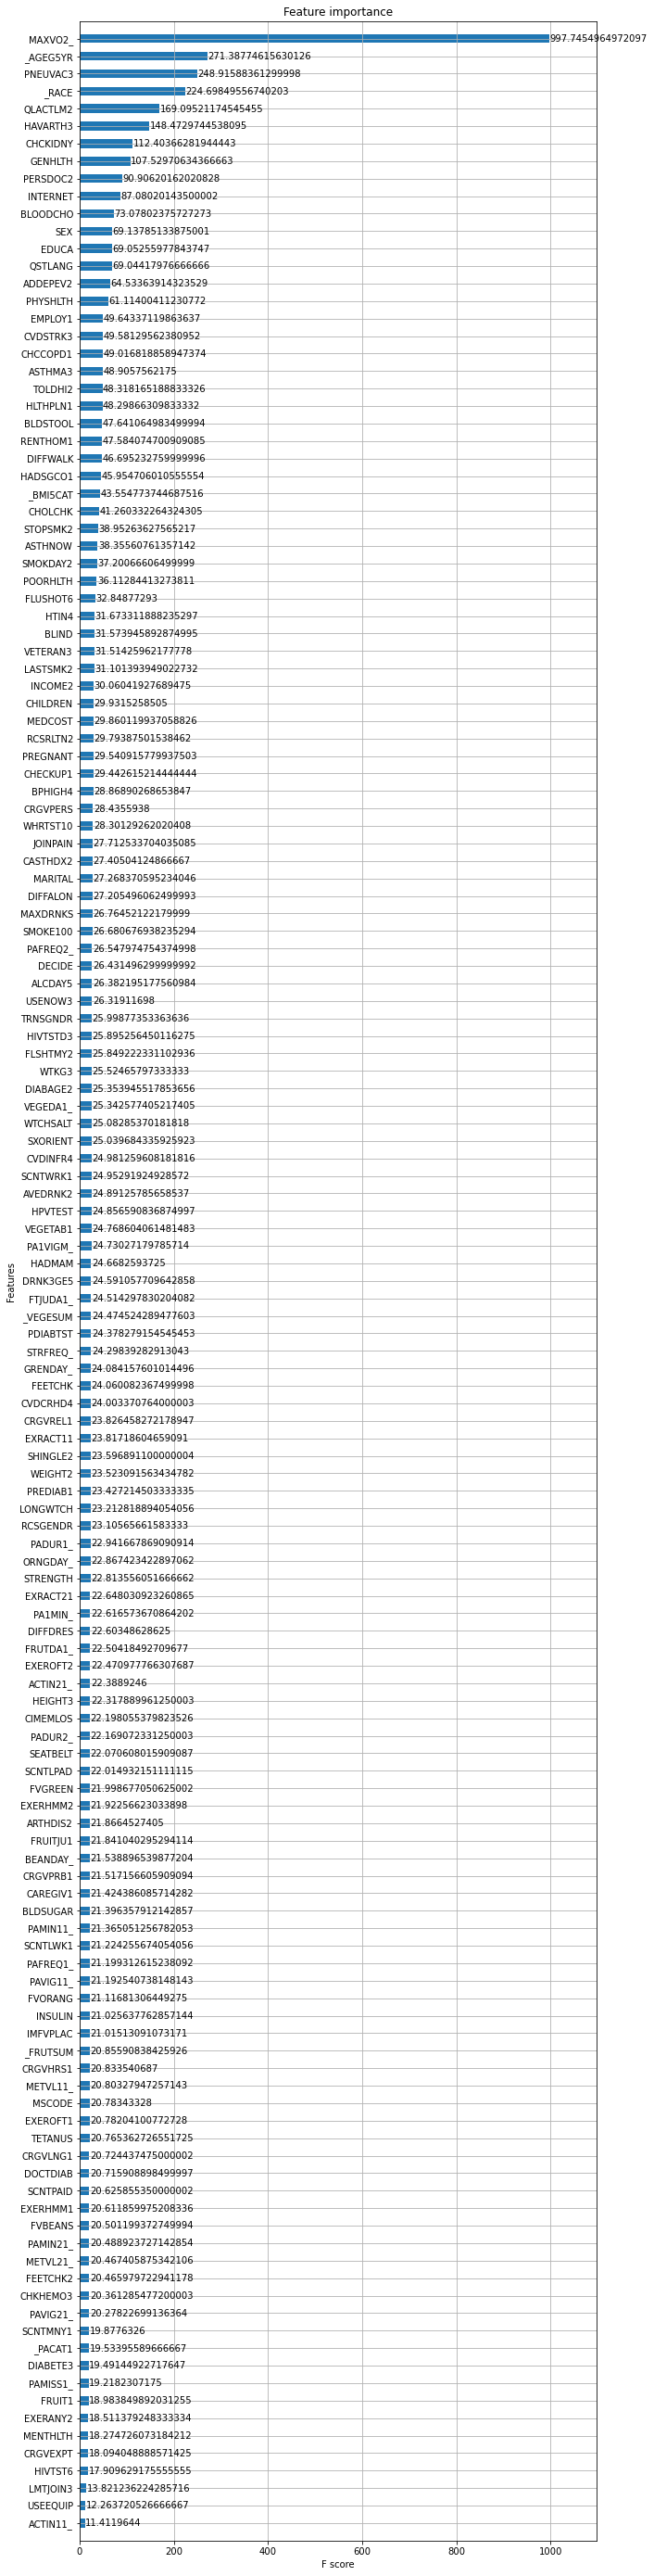

In [87]:
# Plot feature importance
ax = plot_importance(model, height=0.5, importance_type="gain")

fig = ax.figure
fig.set_size_inches(10, 50)

In [88]:
y_true, y_pred = y_test, model.predict(X_test_df)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77     72962
           1       0.32      0.74      0.44     15290

    accuracy                           0.68     88252
   macro avg       0.62      0.70      0.61     88252
weighted avg       0.82      0.68      0.72     88252



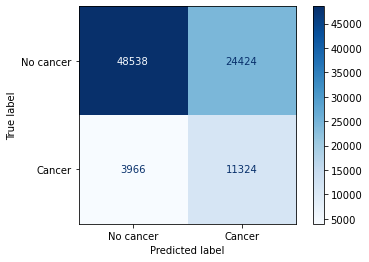

In [89]:
plot_confusion_matrix(model, X_test_df, y_test, display_labels=['No cancer',
 'Cancer'], cmap=plt.cm.Blues)

# Get the right number of features without hampering the accuracy by much

In [105]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold. 
# Since there are only 144 features, select 5 thresholds to decide the right # of features.
thresholds = sort(model.feature_importances_)[[23, 35, 49, 99, 143]]
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print(classification_report(y_test, y_pred))
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 82.68%


/Users/poonam/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:42:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.84      0.98      0.90     72962
           1       0.52      0.11      0.18     15290

    accuracy                           0.83     88252
   macro avg       0.68      0.54      0.54     88252
weighted avg       0.79      0.83      0.78     88252

Thresh=0.003, n=121, Accuracy: 82.85%


/Users/poonam/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.84      0.98      0.90     72962
           1       0.54      0.11      0.19     15290

    accuracy                           0.83     88252
   macro avg       0.69      0.55      0.55     88252
weighted avg       0.79      0.83      0.78     88252

Thresh=0.003, n=109, Accuracy: 82.96%


/Users/poonam/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:44:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.84      0.98      0.90     72962
           1       0.54      0.11      0.18     15290

    accuracy                           0.83     88252
   macro avg       0.69      0.55      0.54     88252
weighted avg       0.79      0.83      0.78     88252

Thresh=0.004, n=95, Accuracy: 82.93%


/Users/poonam/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     72962
           1       0.55      0.10      0.17     15290

    accuracy                           0.83     88252
   macro avg       0.69      0.54      0.54     88252
weighted avg       0.79      0.83      0.78     88252

Thresh=0.005, n=45, Accuracy: 82.99%


/Users/poonam/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     72962
           1       0.52      0.00      0.01     15290

    accuracy                           0.83     88252
   macro avg       0.68      0.50      0.46     88252
weighted avg       0.77      0.83      0.75     88252

Thresh=0.161, n=1, Accuracy: 82.68%


In [106]:
# Take only first 45 important features and check recall
sorted_indices = model.feature_importances_.argsort()
imp_features = dataset.columns[sorted_indices][-45:]

In [107]:
imp_features

Index(['CRGVPERS', 'BPHIGH4', 'CHECKUP1', 'PREGNANT', 'RCSRLTN2', 'MEDCOST',
       'CHILDREN', 'INCOME2', 'LASTSMK2', 'VETERAN3', 'BLIND', 'HTIN4',
       'FLUSHOT6', 'POORHLTH', 'SMOKDAY2', 'ASTHNOW', 'STOPSMK2', 'CHOLCHK',
       '_BMI5CAT', 'HADSGCO1', 'DIFFWALK', 'RENTHOM1', 'BLDSTOOL', 'HLTHPLN1',
       'TOLDHI2', 'ASTHMA3', 'CHCCOPD1', 'CVDSTRK3', 'EMPLOY1', 'PHYSHLTH',
       'ADDEPEV2', 'QSTLANG', 'EDUCA', 'SEX', 'BLOODCHO', 'INTERNET',
       'PERSDOC2', 'GENHLTH', 'CHCKIDNY', 'HAVARTH3', 'QLACTLM2', '_RACE',
       'PNEUVAC3', '_AGEG5YR', 'MAXVO2_'],
      dtype='object')

In [128]:
imp_features_dataset = dataset[imp_features]

In [129]:
# Check current dataset shape
display(imp_features_dataset.shape)

(441257, 45)

In [130]:
# Insert back the labels to the dataset
imp_features_dataset.insert(len(imp_features_dataset.columns), 'Cancerlabels', labels_both)

In [131]:
# Check dataset shape after labels insertion
display(imp_features_dataset.shape)

(441257, 46)

In [135]:
imp_features_dataset.to_csv('data/preprocessed_dataset.csv', index=False)

In [140]:
small_sizedataset = imp_features_dataset.sample(frac = .02,random_state=42);

In [142]:
display(small_sizedataset.shape)

(8825, 46)

In [143]:
small_sizedataset.to_csv('data/small_size_dataset.csv', index=False)